<a href="https://colab.research.google.com/github/nickchak21/QuarkGluonClassifiers/blob/master/Executable_Colab_Notebooks/EMD_tagger_sim_second_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install energyflow
!pip install h5py

     |████████████████████████████████| 686kB 6.5MB/s 
     |████████████████████████████████| 2.9MB 48.6MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [2]:
!python --version

Python 3.6.8


In [3]:
!pip install POT

     |████████████████████████████████| 307kB 6.7MB/s 


In [0]:
import numpy as np
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import energyflow as ef


#%jsroot on
from energyflow.emd import emd, emds
from energyflow.datasets import qg_jets
from energyflow.utils import sum_ptyphipids
import ot

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

In [0]:
from ot.lp import emd_c, check_result
from scipy.spatial.distance import _distance_wrap

In [0]:
# data controls.
# we will use the n nearest neighbors in the "electorate" to vote on what kind of jet each candidate is.
candidates, electorate = 200, 2000

In [8]:
# load quark and gluon jets from simulation. We want candidates + electorate of *each.*
#It takes FOREVER to download these jets. Probably because the simulation gives us more data about the jets.
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
amount = 0.00001
extrajets = candidates
sim = ef.mod.load(*specs, dataset='sim', amount=amount)
maxevts = candidates+electorate
nprint = int(maxevts*maxevts/10)

# the jet radius for these jets
jetR = 0.4

In [24]:
Gs = []
Qs = []

for arr,events in [(Gs, sim.particles[sim.jets_i[:,sim.hard_pid]==21][maxevts:]), (Qs, sim.particles[sim.jets_i[:,sim.hard_pid]!=21][maxevts:])]:
    i = 2200
    for x in events:
        if i >= maxevts+2200:  break
        # ignore padded particles (not used) and remove particle id information(:3)
        x = x[x[:,0] > 0,:3]
        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg
        # mask out any particles farther than R=0.4 away from center (rare)
        x = x[np.linalg.norm(x[:,1:3], axis=1) <= jetR]
        # add to list
        arr.append(x)
        pass #evts
        i+=1
    pass #gluonquark

len(Gs), len(Qs)

(2200, 2200)

In [25]:
constituentList = Gs[candidates:]+Qs[candidates:]
len(constituentList)

4000

In [26]:
#array of distances of gluon candidate from all constituents. shape is (candidates,constituents)
costM_g  = emds(Gs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)
#ditto for quarks.
costM_q  = emds(Qs[0:candidates], constituentList, R=jetR, norm=True, verbose=1, n_jobs=4, print_every=nprint)

Processed 4200 events for asymmetric EMD computation in 0.076s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 92.62s
  Computed 800000 EMDs, 100.00% done in 150.44s
Processed 4200 events for asymmetric EMD computation in 0.070s
Using 4 worker processes:
  Computed 484000 EMDs, 60.50% done in 68.84s
  Computed 800000 EMDs, 100.00% done in 116.28s


In [0]:
indicesG=np.argsort(costM_g)
indicesQ=np.argsort(costM_q)

In [0]:
h_Gten_array = []
h_Qten_array = []
h_Gtwt_array = []
h_Qtwt_array = []

nVoters = 10
for i in range(candidates): h_Gten_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
for i in range(candidates): h_Qten_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
nVoters = 20
for i in range(candidates): h_Gtwt_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)  
for i in range(candidates): h_Qtwt_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)

In [29]:
print(h_Gten_array)
print(h_Qten_array)

[0.7, 0.9, 0.6, 0.4, 0.1, 0.8, 0.7, 0.3, 0.0, 0.8, 0.6, 0.9, 0.5, 0.7, 0.6, 0.9, 0.1, 0.6, 0.4, 0.5, 0.7, 0.2, 0.4, 0.2, 0.3, 0.1, 0.7, 0.6, 0.7, 0.5, 0.2, 0.6, 0.4, 0.8, 0.2, 0.7, 0.7, 1.0, 0.6, 0.5, 0.2, 0.9, 0.7, 0.0, 0.9, 0.6, 0.7, 0.6, 0.8, 0.6, 0.3, 0.5, 0.5, 0.5, 0.4, 0.8, 0.4, 0.1, 0.8, 0.6, 0.3, 0.8, 0.6, 0.2, 0.1, 0.9, 0.5, 0.9, 0.9, 0.3, 0.7, 0.7, 0.2, 0.7, 0.9, 0.6, 0.6, 0.7, 0.5, 0.7, 0.8, 0.7, 0.8, 0.6, 0.3, 0.5, 0.6, 0.6, 0.0, 0.6, 0.9, 0.1, 0.7, 0.6, 0.6, 0.7, 0.6, 0.0, 0.6, 0.8, 0.6, 0.3, 0.6, 0.5, 0.5, 0.7, 0.7, 0.6, 0.7, 0.7, 0.7, 0.3, 0.7, 0.6, 0.6, 0.3, 0.8, 0.3, 0.6, 0.6, 0.1, 0.6, 0.5, 0.4, 0.5, 0.5, 0.9, 0.9, 0.7, 0.5, 0.2, 0.6, 0.6, 0.7, 0.6, 0.8, 0.7, 0.7, 0.6, 0.4, 0.6, 0.9, 0.7, 0.3, 0.6, 0.6, 0.5, 0.4, 0.8, 0.8, 0.2, 0.6, 0.6, 0.7, 0.4, 0.1, 0.7, 0.7, 0.8, 0.6, 0.6, 0.4, 0.6, 0.8, 0.8, 0.3, 0.8, 0.3, 0.1, 0.7, 0.4, 0.4, 0.5, 0.3, 0.7, 0.5, 0.4, 0.9, 0.8, 0.5, 0.3, 0.5, 0.7, 0.0, 0.5, 0.6, 0.7, 0.7, 1.0, 0.4, 0.5, 0.2, 0.4, 0.6, 0.6, 0.4, 0.4, 0.0, 0.7, 0.0]

In [0]:
h_Gten_nparray = np.asarray(h_Gten_array)
h_Qten_nparray = np.asarray(h_Qten_array)
h_Gtwt_nparray = np.asarray(h_Gtwt_array)
h_Qtwt_nparray = np.asarray(h_Qtwt_array)

In [0]:
true_y_g = np.ones(200)
true_y_q = np.zeros(200)

true_values = np.concatenate([true_y_g, true_y_q])

ten_predicted = np.concatenate([h_Gten_nparray, h_Qten_nparray])
emd_auc_10 = roc_auc_score(y_true=true_values, y_score=ten_predicted)

In [32]:
print("EMD AUC 10 voters: ", emd_auc_10)

EMD AUC 10 voters:  0.6875375


In [33]:
twt_predicted = np.concatenate([h_Gtwt_nparray, h_Qtwt_nparray])
emd_auc_20 = roc_auc_score(y_true=true_values, y_score=twt_predicted)
print("EMD AUC 20 voters: ", emd_auc_20)

EMD AUC 20 voters:  0.703225


In [0]:
h_G_array = []
h_Q_array = []
emd_list = []

Testing out different numbers of voters to find an optimum

In [0]:
for nVoters in range(10,200):
    for i in range(candidates): h_G_array.append(sum(indicesG[i,:nVoters] < electorate)/nVoters)
    for i in range(candidates): h_Q_array.append(sum(indicesQ[i,:nVoters] < electorate)/nVoters)
    h_G_nparray = np.asarray(h_G_array)
    h_Q_nparray = np.asarray(h_Q_array)
    predicted = np.concatenate([h_G_nparray, h_Q_nparray])
    emd_auc = roc_auc_score(y_true=true_values, y_score=predicted)
    emd_list.append(emd_auc)
    h_G_array = []
    h_Q_array = []

emd_auc_array = np.asarray(emd_list)

In [36]:
print(emd_auc_array)

[0.6875375 0.6878625 0.6909    0.6960625 0.694575  0.6986375 0.7017
 0.7001375 0.705625  0.7034625 0.703225  0.70595   0.7036875 0.7033125
 0.7011    0.703975  0.703125  0.7056375 0.7083125 0.7093625 0.7134625
 0.7160625 0.7205125 0.72045   0.7203375 0.7198875 0.7183375 0.719
 0.7196375 0.718375  0.7175125 0.7175625 0.71695   0.7178625 0.71915
 0.7185375 0.7191375 0.7203625 0.719975  0.719975  0.71855   0.719125
 0.7194625 0.7205875 0.7198375 0.7193    0.7175875 0.7162    0.717225
 0.71705   0.7173375 0.717525  0.716725  0.7160875 0.7145125 0.7162375
 0.7175375 0.71735   0.717375  0.71615   0.7162375 0.7160875 0.716175
 0.7153    0.714775  0.713425  0.7106625 0.7089875 0.70845   0.7085
 0.7078875 0.708     0.7088375 0.707775  0.7072125 0.7072125 0.7084375
 0.708375  0.7078375 0.7075375 0.7072125 0.70705   0.7072625 0.7082875
 0.7093375 0.7100875 0.7089625 0.7087    0.7091125 0.7071875 0.7066125
 0.70725   0.7085375 0.707975  0.7072375 0.7066125 0.70745   0.7080375
 0.7087    0.7093625 

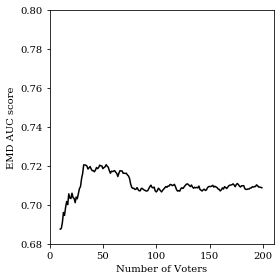

In [39]:
number_voters = np.arange(10,200)
if plt:
    # some nicer plot settings
    plt.rcParams['figure.figsize'] = (4,4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True

    # plot the ROC curves
    plt.plot(number_voters, emd_auc_array, '-', color='black')

     # axes labels
    plt.xlabel('Number of Voters')
    plt.ylabel('EMD AUC score')

    # axes limits
    plt.xlim(0, 210)
    plt.ylim(0.680, 0.800)

    plt.show()

In [37]:
max_auc = np.amax(emd_auc_array)
print(max_auc)

0.7205875


In [38]:
opt_voters = np.argmax(emd_auc_array) + 10 #since we started with 10 voters
print(opt_voters)

53
